# Community Risk Intelligence Agent — Submission Notebook

**Track:** Agents for Good — *Community Risk & Alert Agent*

**Author:** Md Kamran Akhter

---

### Abstract
This notebook packages a production-ready multi-agent system that detects, classifies, and responds to community risks. It integrates Google ADK's LlmAgent with Gemini (GeminiLLM_ADK), an environment-aware DataAgent (optional WeatherTool enrichment), an explainable RiskAnalysisAgent, CommunityAgent routing, and GuideAgent guidance generation. All decisions are logged to enable audit and evaluation.

Run the cells in order. Use the toggle cell to switch between the deterministic LocalStubLLM (for reproducible evaluation) and the ADK Gemini adapter (for live runs).

# Quickstart — Run / Skip (Offline vs Live)

**Quick guide**: which cells to run for each mode.

**Offline (LocalStubLLM)**:
- Run top cells in order. Ensure `LocalStubLLM` cell is executed and `LLM = LocalStubLLM()` is set.
- Skip/comment any ADK/Gemini adapter assignment cells that set `LLM` to a Gemini adapter.
- Recommended: run the demo runner cell for a short duration, then run the comparison harness to produce `compare_results.jsonl`.

**Live (Gemini via ADK)**:
- Set `GOOGLE_API_KEY` in environment or Kaggle Secrets before running the Gemini adapter cell.
- Run the ADK/Gemini adapter cell (it will set `LLM` to a Gemini wrapper). Then run the agent wiring cells and demo.
- Be cautious: live runs consume token quota. Use short demo durations at first.

## Submission README

**Project:** Community Risk Intelligence Agent (ADK + Gemini)

**How to run (quick):**

1. Ensure this notebook's cells are executed in order.
2. (Optional) For live Gemini runs: Install ADK & genai and set `GOOGLE_API_KEY` in Kaggle Secrets. See the toggle cell.
3. Run the demo: `await demo_run_with_memory(duration_sec=20, interval=3)` or `await demo_run_with_weather(...)` for weather enrichment.

**Artifacts produced:**
- `/kaggle/working/agent_logs` — structured logs
- `/kaggle/working/agent_memory` — memory JSONL files and `compare_results.jsonl`
- `/kaggle/working/metrics.json` — metrics snapshot

## Architecture Diagram (ASCII)

```
                 ┌─────────────────────┐
                 │     DataAgent       │
                 │  (stream generator) │
                 └──────────┬──────────┘
                            │ raw_event
                            ▼
                 ┌─────────────────────┐
                 │  RiskAnalysisAgent  │
                 │  (Gemini LLM ADK)   │
                 └──────────┬──────────┘
                            │ alert
         ┌──────────────────┼────────────────────┐
         ▼                  ▼                    ▼
┌────────────────┐  ┌──────────────────┐  ┌─────────────────┐
│ CommunityAgent │  │  GuideAgent      │  │ Decision Memory │
│ routes by user │  │ generates advice │  │ & Observability │
└────────────────┘  └──────────────────┘  └─────────────────┘
```

**Components:**
- DataAgent: ingests or simulates event streams and optionally enriches with WeatherTool.
- RiskAnalysisAgent: classifies events using Gemini (via ADK) and writes decisions to memory.
- CommunityAgent: routes alerts to users by location.
- GuideAgent: generates human-actionable checklists using LLM.
- Observability & Memory: structured logs + JSONL memory stores for audit and evaluation.


# Community Risk & Alert Agent — Capstone Notebook

This notebook contains the full scaffold for the Community Risk & Alert Agent (Agents for Good track). It is Kaggle-ready and uses only standard Python libraries (requests, asyncio, json, etc.).

Sections:
1. Imports & setup
2. LLM interface + Local stub
3. Event bus & Agent base
4. Sessions & Memory stores
5. Helper utilities (retry, structured logging, events)
6. Agents (DataAgent, RiskAnalysisAgentWithMemory, CommunityAgentWithMemory, GuideAgentWithMemory)
7. Observability & Metrics
8. WeatherTool (real-data enrichment)
9. Environmental heuristics
10. Demo runners and comparison harness
11. Metrics and Visualization
12. CLEANUP & Artifact summary

Run cells in order. To run real weather enrichment, no API key is required (uses open-meteo).


## 📖 Get started with Kaggle Notebooks

If this is your first time using Kaggle Notebooks, welcome! You can learn more about using Kaggle Notebooks [in the documentation](https://www.kaggle.com/docs/notebooks).

Here's how to get started:

**1. Verify Your Account (Required)**

To use this Kaggle Notebook, you'll need to verify your account with a phone number.

You can do this in your [Kaggle settings](https://www.kaggle.com/settings).

**2. Make Your Own Copy**

To run any code in this notebook, you first need your own editable copy.

Click the `Copy and Edit` button in the top-right corner.

![Copy and Edit button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_1.png)

This creates a private copy of the notebook just for you.

**3. Run Code Cells**

Once you have your copy, you can run code.

Click the ▶️ Run button next to any code cell to execute it.

![Run cell button](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_2.png)

Run the cells in order from top to bottom.

**4. If You Get Stuck**

To restart: Select `Factory reset` from the `Run` menu.

For help: Ask questions on the [Kaggle Discord](https://discord.com/invite/kaggle) server.

### Install dependencies

The Kaggle Notebooks environment includes a pre-installed version of the [google-adk](https://google.github.io/adk-docs/) library for Python and its required dependencies, so you don't need to install additional packages in this notebook.

To install and use ADK, including A2A and its dependencies, in your own Python development environment outside of this course, you can do so by running:

```
pip install google-adk
```

In [1]:
# 00_install_deps
# Install runtime dependencies (run once). Pin versions for reproducibility.
# Uncomment the following if packages are not installed in the environment.
# NOTE: in Kaggle you may need to enable internet or use available packages.
# !pip install --quiet google-genai google-adk==0.1.0  # example versions
# !pip install --quiet requests nbformat
print('Install step: verify packages are available. (No action taken)')

Install step: verify packages are available. (No action taken)


In [ ]:
# Try to import the project package (fall back to notebook definitions if not present)
try:
    from project_package.agents import LocalStubLLM, RiskAnalysisAgent, EventBus, compute_env_score
    print('Imported classes from project_package.agents')
except Exception as e:
    print('project_package not available or import failed — using notebook-local definitions. Error:', e)


### Configure your Gemini API Key (Required for Live Runs)

This notebook also uses the [Gemini API](https://ai.google.dev/gemini-api/docs), which requires authentication.

**1. Get your API key**

If you don't have one already, create an [API key in Google AI Studio](https://aistudio.google.com/app/api-keys).

**2. Add the key to Kaggle Secrets**

Next, you will need to add your API key to your Kaggle Notebook as a Kaggle User Secret.

1. In the top menu bar of the notebook editor, select `Add-ons` then `Secrets`.
2. Create a new secret with the label `GOOGLE_API_KEY`.
3. Paste your API key into the "Value" field and click "Save".
4. Ensure that the checkbox next to `GOOGLE_API_KEY` is selected so that the secret is attached to the notebook.

**3. Authenticate in the notebook**

Run the cell below to complete authentication.

In [2]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "FALSE"
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}")

✅ Gemini API key setup complete.


## ⚙️ 1. Imports & setup

In [3]:
import asyncio, time, json, uuid, random, os, requests, statistics
from datetime import datetime, timezone
from typing import Dict, Any, List, Optional, Callable
os.makedirs('/kaggle/working/agent_logs', exist_ok=True)
os.makedirs('/kaggle/working/agent_memory', exist_ok=True)


## 2. LLM Interface & Local stub (deterministic for offline tests)

In [4]:
class LLMInterface:
    async def classify_event(self, event: Dict[str, Any]) -> Dict[str, Any]:
        raise NotImplementedError
    async def generate_guidance(self, alert: Dict[str, Any]) -> str:
        raise NotImplementedError

class LocalStubLLM(LLMInterface):
    async def classify_event(self, event: Dict[str, Any]) -> Dict[str, Any]:
        base = event.get('meta', {}).get('severity_hint', 0.1)
        type_map = {'fire': 0.9, 'air_quality': 0.6, 'weather': 0.4, 'news': 0.3, 'transport': 0.2}
        score = min(1.0, base * 0.7 + type_map.get(event['type'], 0.2) * 0.5)
        category = 'high' if score > 0.7 else ('medium' if score > 0.4 else 'low')
        rationale = f"Heuristic: base={base:.2f}, type_weight={type_map.get(event['type'],0.2):.2f} -> score={score:.2f}"
        return {'score': score, 'category': category, 'rationale': rationale}

    async def generate_guidance(self, alert: Dict[str, Any]) -> str:
        cat = alert.get('category', 'low')
        if cat == 'high':
            checklist = ['Move to a safe area immediately; follow local emergency services instructions.',
                         'Take essential documents and emergency kit (water, medicines).',
                         'Help neighbors if safe to do so; call helpline if injured.']
        elif cat == 'medium':
            checklist = ['Monitor official channels.', 'Avoid non-essential travel in affected zones.']
        else:
            checklist = ['No immediate action; stay informed.']
        return "Guidance (auto):\n- " + "\n- ".join(checklist)

# Default LLM for the notebook
LLM = LocalStubLLM()
print("LLM Interface & Local stub has been defined✅")


LLM Interface & Local stub has been defined✅


In [5]:
# Helpers: enable_offline() and enable_gemini()
import os
def enable_offline():
    try:
        globals()['LLM'] = LocalStubLLM()
        print('LLM set to LocalStubLLM (offline mode).')
    except NameError:
        raise RuntimeError('LocalStubLLM not defined. Run the cell that defines LocalStubLLM first.')

def enable_gemini(model_name='gemini-2.5-flash-lite'):
    if not os.environ.get('GOOGLE_API_KEY'):
        raise RuntimeError('GOOGLE_API_KEY not found in environment. Set it via Kaggle Secrets or os.environ.')
    try:
        globals()['LLM'] = GeminiLLM_ADK(model_name=model_name)  # GeminiLLM_ADK must be defined
        print(f'LLM set to GeminiLLM_ADK(model_name={model_name}).')
    except NameError:
        raise RuntimeError('GeminiLLM_ADK not defined. Run the Gemini adapter definition cell first.')
print("Helper function has been defined✅")

Helper function has been defined✅


In [6]:
# Secrets check for Gemini/ADK
import os
key = os.environ.get('GOOGLE_API_KEY')
if key:
    print('GOOGLE_API_KEY is present in the environment (kept hidden).')
else:
    print('GOOGLE_API_KEY is NOT present. Set it via Kaggle Secrets or os.environ before running Gemini.')

GOOGLE_API_KEY is present in the environment (kept hidden).


In [7]:
# Retry & backoff wrapper for network/LLM calls
import time
import functools
def retry_with_backoff(max_retries=3, initial_delay=1.0, backoff_factor=2.0, allowed_exceptions=(Exception,)):
    def decorator(fn):
        @functools.wraps(fn)
        def wrapper(*args, **kwargs):
            delay = initial_delay
            for attempt in range(1, max_retries+1):
                try:
                    return fn(*args, **kwargs)
                except allowed_exceptions as e:
                    if attempt == max_retries:
                        raise
                    print(f'Call failed (attempt {attempt}), retrying in {delay}s...: {e}')
                    time.sleep(delay)
                    delay *= backoff_factor
        return wrapper
    return decorator

# Example usage: decorate LLM call wrappers in your code, e.g.
# @retry_with_backoff(max_retries=3)
# async def safe_classify(...): ...

In [8]:
# Unit tests: quick assertions for core functions (run after LocalStubLLM is defined)
import json, uuid, asyncio, sys
def _run_async(coro):
    return asyncio.get_event_loop().run_until_complete(coro)

try:
    # Simple synthetic event expected to produce deterministic LocalStubLLM outputs
    sample_event = {'id': str(uuid.uuid4()), 'type': 'weather', 'location': 'downtown', 'meta': {'severity_hint': 0.1}}
    if 'LocalStubLLM' in globals():
        llm = LocalStubLLM()
        out = await llm.classify_event(sample_event)
        assert 'score' in out and 'category' in out, 'LocalStubLLM classify_event missing keys'
        print('LocalStubLLM basic test passed:', out)
    else:
        print('LocalStubLLM not present — skip unit test.')
except AssertionError as e:
    print('Unit test failed:', e)
    raise

LocalStubLLM basic test passed: {'score': 0.27, 'category': 'low', 'rationale': 'Heuristic: base=0.10, type_weight=0.40 -> score=0.27'}


In [9]:
# ---- ADK-based Gemini adapter (inserted) ----
# Install once: !pip install --quiet google-adk google-genai
import os, json, asyncio
try:
    from google.adk.agents import LlmAgent
    from google.adk.models.google_llm import Gemini
    from google.adk.runners import InMemoryRunner
    _adk_import_error = None
except Exception as e:
    LlmAgent = None
    Gemini = None
    InMemoryRunner = None
    _adk_import_error = e

class GeminiLLM_ADK:
    """ADK-based Gemini adapter that matches the scaffold's LLMInterface."""
    def __init__(self, model_name='gemini-2.5-flash-lite', retry_options=None):
        if Gemini is None:
            raise RuntimeError(f"ADK import failed: {_adk_import_error}. Run `!pip install google-adk google-genai` and set GOOGLE_API_KEY.")
        self.model_name = model_name
        self.retry_options = retry_options or {}

    def _build_agent(self):
        model = Gemini(model=self.model_name, retry_options=self.retry_options)
        agent = LlmAgent(model=model, name='adk_temp_agent', description='Transient agent for scaffold calls')
        return agent

    async def _run_prompt(self, prompt: str) -> str:
        agent = self._build_agent()
        runner = InMemoryRunner(agent=agent)
        resp = await runner.run_debug(prompt)
        try:
            text = getattr(resp, 'output', None) or getattr(resp, 'text', None) or str(resp)
        except Exception:
            text = str(resp)
        return text

    async def classify_event(self, event: dict) -> dict:
        prompt = (
            "You are an analyst. Classify the following event for severity and give a numerical score 0-1 and a short rationale. Return ONLY a JSON object with keys: score (0-1), category (low|medium|high), rationale.\n\n"
            f"Event: {json.dumps(event, default=str)}"
        )
        raw = await self._run_prompt(prompt)
        try:
            first = raw.find('{'); last = raw.rfind('}')
            if first != -1 and last != -1 and last > first:
                parsed = json.loads(raw[first:last+1])
            else:
                parsed = json.loads(raw)
            return {'score': float(parsed.get('score', 0.0)), 'category': parsed.get('category', 'low'), 'rationale': parsed.get('rationale', '')}
        except Exception:
            import re
            m = re.search(r"(0\.\d+|1(?:\.0+)?)", raw)
            score = float(m.group(1)) if m else 0.5
            cat = 'high' if score > 0.7 else ('medium' if score > 0.4 else 'low')
            return {'score': score, 'category': cat, 'rationale': raw}

    async def generate_guidance(self, alert: dict) -> str:
        prompt = (
            "You are an emergency response advisor. Produce a short, actionable checklist (3-6 items) tailored to the alert below. Return plain text.\n\n"
            f"Alert: {json.dumps(alert, default=str)}"
        )
        return await self._run_prompt(prompt)

In [10]:
# ---- Toggle ADK Gemini LLM ----
# Install once:
# !pip install --quiet google-adk google-genai
# Set your key in Kaggle Secrets as GOOGLE_API_KEY and then:
# from kaggle_secrets import UserSecretsClient
# secrets = UserSecretsClient()
# os.environ['GOOGLE_API_KEY'] = secrets.get_secret('GOOGLE_API_KEY')
# Finally uncomment and run:
LLM = GeminiLLM_ADK(model_name='gemini-2.5-flash-lite')


## 3. Event bus and Agent base classes

In [11]:
class EventBus:
    def __init__(self):
        self._subs = {}
    def subscribe(self, event_name: str, handler):
        self._subs.setdefault(event_name, []).append(handler)
    async def publish(self, event_name: str, payload: Dict[str, Any]):
        handlers = self._subs.get(event_name, [])
        if not handlers:
            return
        await asyncio.gather(*(h(payload) for h in handlers))

class Agent:
    def __init__(self, name: str, bus: EventBus):
        self.name = name
        self.bus = bus
    def log(self, obj: Dict[str, Any]):
        obj_line = json.dumps(obj, default=str)
        with open(f"/kaggle/working/agent_logs/{self.name}.log", 'a') as f:
            f.write(obj_line + '\n')


## 4. Sessions & Memory (file-backed)

In [12]:
MEM_DIR = '/kaggle/working/agent_memory'
def _now_iso():
    return datetime.now(timezone.utc).isoformat()

class MemoryStore:
    def __init__(self, namespace: str):
        self.namespace = namespace
        self.path = os.path.join(MEM_DIR, f'{namespace}.jsonl')
        open(self.path, 'a').close()
    def write(self, entry: Dict[str, Any]) -> None:
        record = {'ts': _now_iso(), **entry}
        with open(self.path, 'a') as f:
            f.write(json.dumps(record, default=str) + '\n')
    def read_all(self) -> List[Dict[str, Any]]:
        out = []
        with open(self.path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    out.append(json.loads(line))
                except Exception:
                    out.append({'ts': _now_iso(), 'raw': line, 'error': 'parse_failed'})
        return out
    def query(self, predicate_fn: Callable[[Dict[str, Any]], bool]) -> List[Dict[str, Any]]:
        return [e for e in self.read_all() if predicate_fn(e)]

class SessionManager:
    SESSIONS_FILE = os.path.join(MEM_DIR, 'sessions.json')
    def __init__(self):
        if not os.path.exists(self.SESSIONS_FILE):
            with open(self.SESSIONS_FILE, 'w') as f:
                json.dump({}, f)
    def _load(self) -> Dict[str, Any]:
        with open(self.SESSIONS_FILE, 'r') as f:
            return json.load(f)
    def _save(self, obj: Dict[str, Any]) -> None:
        with open(self.SESSIONS_FILE, 'w') as f:
            json.dump(obj, f, default=str, indent=2)
    def create_session(self, session_id: Optional[str] = None, context: Optional[Dict[str, Any]] = None) -> str:
        s = session_id or f'session-{uuid.uuid4()}'
        all_s = self._load()
        now = _now_iso()
        all_s[s] = {'session_id': s, 'created_ts': now, 'last_updated_ts': now, 'context': context or {}}
        self._save(all_s)
        return s
    def get_session(self, session_id: str) -> Optional[Dict[str, Any]]:
        return self._load().get(session_id)
    def update_session(self, session_id: str, patch: Dict[str, Any]) -> bool:
        all_s = self._load()
        if session_id not in all_s:
            return False
        all_s[session_id]['context'].update(patch)
        all_s[session_id]['last_updated_ts'] = _now_iso()
        self._save(all_s)
        return True
    def list_sessions(self) -> List[Dict[str, Any]]:
        return list(self._load().values())

# instantiate stores
decision_mem = MemoryStore('risk_decisions')
user_mem = MemoryStore('user_notifications')
guidance_mem = MemoryStore('guidance_store')
sessions = SessionManager()


## 5. Helpers: retry decorator, structured logging, canonical event maker

In [13]:
import functools
def retry_on_exception(max_attempts=3, backoff=1.0, allowed_exceptions=(Exception,)):
    def decorator(fn):
        @functools.wraps(fn)
        def wrapper(*args, **kwargs):
            attempts = 0
            while True:
                try:
                    return fn(*args, **kwargs)
                except allowed_exceptions as e:
                    attempts += 1
                    if attempts >= max_attempts:
                        raise
                    sleep_time = backoff * (2 ** (attempts - 1))
                    time.sleep(sleep_time)
        return wrapper
    return decorator

def structured_log(agent_name: str, record: Dict[str, Any], level: str = 'INFO') -> None:
    payload = {'ts': datetime.now(timezone.utc).isoformat(), 'agent': agent_name, 'level': level, **record}
    path = f"/kaggle/working/agent_logs/{agent_name}.log"
    with open(path, 'a') as f:
        f.write(json.dumps(payload, default=str) + '\n')

def make_event(event_type: str, payload: Dict[str, Any], source: str) -> Dict[str, Any]:
    return {'event_id': str(uuid.uuid4()), 'type': event_type, 'source': source, 'payload': payload, 'timestamp': datetime.now(timezone.utc).isoformat()}

# Monkey-patch Agent.log to use structured_log
_orig_agent_log = Agent.log
def _agent_log_structured(self, obj: Dict[str, Any]):
    try:
        structured_log(self.name, obj, level=obj.get('level', 'INFO'))
    except Exception:
        try:
            _orig_agent_log(self, obj)
        except Exception:
            pass
Agent.log = _agent_log_structured


## 6(a). DataAgent (emits canonical events and can enrich weather events)

In [14]:
LOCATION_COORDS = {'downtown': (28.7041, 77.1025), 'sector-1': (28.7048, 77.1030), 'sector-2': (28.7055, 77.1040), 'sector-3': (28.7062, 77.1050)}

class DataAgent(Agent):
    def __init__(self, name, bus, interval=5, use_real_weather=False, weather_tool=None):
        super().__init__(name, bus)
        self.interval = interval
        self.running = False
        self.use_real_weather = use_real_weather
        self.weather_tool = weather_tool or None

    @retry_on_exception(max_attempts=4, backoff=0.8)
    def external_call_placeholder(self, *args, **kwargs):
        return {'ok': True}

    def _generate_mock_event(self):
        types = ['weather', 'air_quality', 'news', 'transport', 'fire']
        t = random.choice(types)
        severity_hint = random.random()
        location = random.choice(list(LOCATION_COORDS.keys()))
        payload = {'id': str(uuid.uuid4()), 'type': t, 'source': 'mock_provider', 'location': location,
                   'timestamp': datetime.now(timezone.utc).isoformat(),
                   'text': f"Mock {t} event at {location} severity_hint={severity_hint:.2f}", 'meta': {'severity_hint': severity_hint}}
        return make_event('raw_event', payload, source=self.name)

    async def start(self):
        self.running = True
        while self.running:
            e = self._generate_mock_event()
            payload = e['payload']

            if self.use_real_weather and payload['type'] == 'weather' and self.weather_tool:
                coords = LOCATION_COORDS.get(payload['location'])
                if coords:
                    try:
                        w = self.weather_tool.fetch_current_weather(coords[0], coords[1])
                        payload['meta']['weather'] = w
                        payload['text'] = f"Real weather at {payload['location']}: {w.get('summary')}"
                        payload['source'] = 'open-meteo'
                    except Exception as ex:
                        self.log({'level': 'WARN', 'msg': 'weather_fetch_failed', 'error': str(ex), 'location': payload['location']})

            self.log({'event': e})
            try:
                metrics.incr('events_received', 1)
            except Exception:
                pass
            await self.bus.publish('raw_event', payload)
            await asyncio.sleep(self.interval)

    def stop(self):
        self.running = False


## 6(b). Memory-enabled agents (Risk, Community, Guide)

In [15]:
class RiskAnalysisAgent(Agent):
    def __init__(self, name, bus, llm: LLMInterface):
        super().__init__(name, bus)
        self.llm = llm
        bus.subscribe('raw_event', self.on_raw_event)

    async def on_raw_event(self, raw_event: Dict[str, Any]):
        try:
            result = await self.llm.classify_event(raw_event)
        except Exception as e:
            self.log({'ts': _now_iso(), 'error': str(e), 'event': raw_event})
            return
        score = float(result.get('score', 0.0))
        category = result.get('category', 'low')
        rationale = result.get('rationale', '')
        alert = {'alert_id': str(uuid.uuid4()), 'source_event_id': raw_event['id'], 'category': category,
                 'score': score, 'rationale': rationale, 'location': raw_event['location'], 'summary': raw_event['text'],
                 'raw': raw_event, 'timestamp': _now_iso()}
        self.log({'ts': _now_iso(), 'alert': alert})
        if score >= 0.4:
            await self.bus.publish('alert', alert)

# Subclass with memory & sessions
class RiskAnalysisAgentWithMemory(RiskAnalysisAgent):
    def __init__(self, name, bus, llm: LLMInterface):
        super().__init__(name, bus, llm)
    async def on_raw_event(self, raw_event: Dict[str, Any]):
        session_id = sessions.create_session(context={'initiator': self.name, 'event_id': raw_event.get('id')})
        try:
            result = await self.llm.classify_event(raw_event)
        except Exception as e:
            self.log({'ts': _now_iso(), 'error': str(e), 'event': raw_event})
            decision_mem.write({'session_id': session_id, 'agent': self.name, 'event': raw_event, 'error': str(e)})
            return
        score = float(result.get('score', 0.0))
        category = result.get('category', 'low')
        rationale = result.get('rationale', '')
        alert = {'alert_id': str(uuid.uuid4()), 'source_event_id': raw_event['id'], 'category': category,
                 'score': score, 'rationale': rationale, 'location': raw_event['location'], 'summary': raw_event['text'],
                 'raw': raw_event, 'timestamp': _now_iso(), 'session_id': session_id}
        decision_mem.write({'session_id': session_id, 'agent': self.name, 'alert': alert})
        self.log({'ts': _now_iso(), 'alert': alert})
        if score >= 0.4:
            await self.bus.publish('alert', alert)

class CommunityAgentWithMemory(Agent):
    def __init__(self, name, bus, user_profiles: Dict[str, Dict]):
        super().__init__(name, bus)
        self.user_profiles = user_profiles
        bus.subscribe('alert', self.on_alert)
    async def on_alert(self, alert: Dict[str, Any]):
        recipients = [u for u,p in self.user_profiles.items() if p['location'] == alert['location']]
        for uid in recipients:
            notification = f"Alert({alert['category']}) in {alert['location']}: {alert['summary']} -- See guidance"
            print(f"[NOTIFY {uid}] {notification}")
            user_mem.write({'user': uid, 'alert_id': alert['alert_id'], 'notified_at': _now_iso()})

class GuideAgentWithMemory(Agent):
    def __init__(self, name, bus, llm: LLMInterface):
        super().__init__(name, bus)
        self.llm = llm
        bus.subscribe('alert', self.on_alert)
    async def on_alert(self, alert: Dict[str, Any]):
        session_id = alert.get('session_id') or sessions.create_session(context={'alert_id': alert.get('alert_id')})
        try:
            guidance_text = await self.llm.generate_guidance(alert)
        except Exception as e:
            self.log({'ts': _now_iso(), 'error': str(e), 'alert': alert})
            guidance_text = 'Guidance unavailable.'
        guidance_mem.write({'session_id': session_id, 'alert_id': alert.get('alert_id'), 'guidance': guidance_text})
        fn = f"/kaggle/working/agent_logs/guidance_{alert['alert_id']}.json"
        with open(fn, 'w') as f:
            json.dump({'alert': alert, 'guidance': guidance_text}, f, default=str, indent=2)
        print(f"[GUIDE SAVED] {fn}")
        self.log({'ts': _now_iso(), 'guidance_file': fn, 'session_id': session_id})


## 7. Observability: MetricsCollector and wiring

In [16]:
METRICS_PATH = '/kaggle/working/metrics.json'
class MetricsCollector:
    def __init__(self, path=METRICS_PATH):
        self.path = path
        self.metrics = {'events_received': 0, 'alerts_emitted': 0, 'classification_latencies_ms': [], 'last_updated': _now_iso()}
        self._flush()
    def incr(self, key: str, amount: int = 1):
        if key not in self.metrics:
            self.metrics[key] = 0
        self.metrics[key] += amount
        self.metrics['last_updated'] = _now_iso()
        self._flush()
    def record_latency(self, ms: float):
        self.metrics.setdefault('classification_latencies_ms', []).append(ms)
        self.metrics['last_updated'] = _now_iso()
        self._flush()
    def snapshot(self) -> Dict[str, Any]:
        out = dict(self.metrics)
        lat = out.get('classification_latencies_ms', [])
        out['classification_latency_ms_avg'] = statistics.mean(lat) if lat else None
        out['classification_latency_ms_p95'] = (statistics.quantiles(lat, n=100)[94] if len(lat) >= 2 else None)
        return out
    def _flush(self):
        try:
            with open(self.path, 'w') as f:
                json.dump(self.metrics, f, default=str, indent=2)
        except Exception:
            pass
metrics = MetricsCollector()
# Patch DataAgent.start via replacing method reference is not necessary here; we'll rely on demo runners to call metrics where appropriate


## 8. WeatherTool (enhanced parsing of open-meteo)

In [18]:
class WeatherTool:
    def __init__(self):
        self.endpoint = 'https://api.open-meteo.com/v1/forecast'
    @retry_on_exception(max_attempts=3, backoff=0.5, allowed_exceptions=(requests.RequestException,))
    def fetch_current_weather(self, lat: float, lon: float) -> Dict[str, Any]:
        params = {'latitude': lat, 'longitude': lon, 'hourly': 'temperature_2m,windspeed_10m,relativehumidity_2m,pm2_5,pm10', 'timezone': 'UTC'}
        r = requests.get(self.endpoint, params=params, timeout=10)
        r.raise_for_status()
        data = r.json()
        result = {'summary': 'no-data', 'temperature': None, 'windspeed': None, 'humidity': None, 'pm2_5': None, 'pm10': None}
        try:
            hourly = data.get('hourly', {})
            times = hourly.get('time', [])
            if not times:
                return {'summary': 'no-hourly-data', 'raw': data}
            latest_idx = len(times) - 1
            def safe_get(field):
                arr = hourly.get(field, [])
                return arr[latest_idx] if latest_idx < len(arr) else None
            temp = safe_get('temperature_2m')
            wind = safe_get('windspeed_10m')
            rh = safe_get('relativehumidity_2m')
            pm25 = safe_get('pm2_5')
            pm10 = safe_get('pm10')
            parts = []
            if temp is not None:
                parts.append(f"T={temp}°C")
                result['temperature'] = temp
            if wind is not None:
                parts.append(f"Wind={wind}m/s")
                result['windspeed'] = wind
            if rh is not None:
                parts.append(f"RH={rh}%")
                result['humidity'] = rh
            if pm25 is not None:
                parts.append(f"PM2.5={pm25}")
                result['pm2_5'] = pm25
            if pm10 is not None:
                parts.append(f"PM10={pm10}")
                result['pm10'] = pm10
            summary = ', '.join(parts) if parts else 'no-metrics'
            result['summary'] = summary
            result['raw'] = data
        except Exception as e:
            return {'summary': 'parse-error', 'error': str(e), 'raw': data}
        return result


## 9. Environmental heuristic and integration

In [20]:
def assess_environmental_risk_from_weather(meta: Dict[str, Any]) -> float:
    if not meta:
        return 0.0
    w = meta.get('weather') or {}
    pm25 = w.get('pm2_5')
    temp = w.get('temperature')
    rh = w.get('humidity')
    wind = w.get('windspeed')
    if pm25 is not None:
        pm_score = min(1.0, float(pm25) / 150.0)
    else:
        pm_score = 0.0
    if temp is not None:
        temp_dev = abs(float(temp) - 25.0) / 25.0
        temp_score = min(1.0, temp_dev)
    else:
        temp_score = 0.0
    if rh is not None:
        rh_val = float(rh)
        rh_score = 1.0 if (rh_val > 85 or rh_val < 20) else 0.0
    else:
        rh_score = 0.0
    if wind is not None:
        wind_score = max(0.0, 1.0 - min(15.0, float(wind)) / 15.0)
    else:
        wind_score = 1.0
    score = 0.6 * pm_score + 0.2 * temp_score + 0.1 * rh_score + (-0.1) * (1.0 - wind_score)
    score = max(0.0, min(1.0, score))
    return score

# Monkey-patch RiskAnalysisAgentWithMemory to apply heuristic before classification
_orig_on_raw = RiskAnalysisAgentWithMemory.on_raw_event
async def _patched_on_raw(self, raw_event):
    meta = raw_event.get('meta', {})
    env_score = assess_environmental_risk_from_weather(meta)
    meta['env_risk_score'] = env_score
    existing_hint = meta.get('severity_hint', 0.0)
    meta['severity_hint'] = max(existing_hint, env_score)
    raw_event['meta'] = meta
    await _orig_on_raw(self, raw_event)
RiskAnalysisAgentWithMemory.on_raw_event = _patched_on_raw


## 10(a). Demo runners: memory-enabled and weather-enriched demos

In [22]:

async def demo_run_with_memory(duration_sec=20, interval=3, use_gemini=False):
    bus = EventBus()
    llm_impl = LLM
    data_agent = DataAgent('DataAgent', bus, interval=interval, use_real_weather=False, weather_tool=None)
    risk_agent = RiskAnalysisAgentWithMemory('RiskAnalysis', bus, llm_impl)
    profiles = {'user_1': {'name':'Asha','location':'downtown'}, 'user_2':{'name':'Rahul','location':'sector-2'}}
    community = CommunityAgentWithMemory('CommunityAgent', bus, profiles)
    guide = GuideAgentWithMemory('GuideAgent', bus, llm_impl)
    tasks = [asyncio.create_task(data_agent.start())]
    start = time.time()
    try:
        while time.time() - start < duration_sec:
            await asyncio.sleep(1)
    finally:
        data_agent.stop()
        await asyncio.sleep(2)

async def demo_run_with_weather(duration_sec=20, interval=3):
    bus = EventBus()
    llm_impl = LLM
    data_agent = DataAgent('DataAgent', bus, interval=interval, use_real_weather=True, weather_tool=WeatherTool())
    risk_agent = RiskAnalysisAgentWithMemory('RiskAnalysis', bus, llm_impl)
    profiles = {'user_1': {'name':'Asha','location':'downtown'}, 'user_2':{'name':'Rahul','location':'sector-2'}}
    community = CommunityAgentWithMemory('CommunityAgent', bus, profiles)
    guide = GuideAgentWithMemory('GuideAgent', bus, llm_impl)
    tasks = [asyncio.create_task(data_agent.start())]
    start = time.time()
    try:
        while time.time() - start < duration_sec:
            await asyncio.sleep(1)
    finally:
        data_agent.stop()
        await asyncio.sleep(2)


## 10(b). Comparison harness (synthetic scenarios) - run to compare heuristic impact

In [23]:

import copy
def make_synthetic_payload(event_type='weather', location='downtown', severity_hint=0.1, weather_meta=None):
    return {'id': f"synthetic-{uuid.uuid4()}", 'type': event_type, 'source': 'synthetic', 'location': location,
            'timestamp': datetime.now(timezone.utc).isoformat(), 'text': f"Synthetic {event_type} event at {location}", 'meta': {'severity_hint': severity_hint, **(weather_meta or {})}}

async def classify_once(llm_impl, payload):
    bus = EventBus()
    risk = RiskAnalysisAgentWithMemory('RiskAnalysis_Temp', bus, llm_impl)
    async def noop(alert): pass
    bus.subscribe('alert', noop)
    await risk.on_raw_event(payload)
    decs = decision_mem.read_all()
    if not decs:
        return None
    for d in reversed(decs):
        a = d.get('alert')
        if a and a.get('source_event_id') == payload['id']:
            return a
    return decs[-1].get('alert') if decs[-1].get('alert') else decs[-1]

def clear_recent_decisions():
    open(decision_mem.path, 'w').close()

test_cases = [
    {'name':'clean_air','weather':{'weather':{'pm2_5':5,'temperature':25,'humidity':50,'windspeed':3}}},
    {'name':'moderate_pm','weather':{'weather':{'pm2_5':60,'temperature':30,'humidity':50,'windspeed':1}}},
    {'name':'high_pm','weather':{'weather':{'pm2_5':180,'temperature':28,'humidity':40,'windspeed':0.5}}},
    {'name':'extreme_heat','weather':{'weather':{'pm2_5':30,'temperature':42,'humidity':20,'windspeed':2}}},
    {'name':'high_humidity','weather':{'weather':{'pm2_5':20,'temperature':26,'humidity':90,'windspeed':0.5}}},
    {'name':'windy','weather':{'weather':{'pm2_5':80,'temperature':27,'humidity':50,'windspeed':12}}},
]

async def run_comparison():
    results = []
    llm_impl = LLM
    for tc in test_cases:
        payload_noenv = make_synthetic_payload(event_type='weather', location='downtown', severity_hint=0.1, weather_meta=None)
        payload_env = make_synthetic_payload(event_type='weather', location='downtown', severity_hint=0.05, weather_meta=tc['weather'])
        clear_recent_decisions()
        a_noenv = await classify_once(llm_impl, copy.deepcopy(payload_noenv))
        decs_noenv = decision_mem.read_all()
        clear_recent_decisions()
        a_env = await classify_once(llm_impl, copy.deepcopy(payload_env))
        decs_env = decision_mem.read_all()
        env_score = assess_environmental_risk_from_weather(tc['weather'])
        results.append({'case':tc['name'],'env_score':env_score,'noenv_decision':a_noenv,'env_decision':a_env,'noenv_decs_count':len(decs_noenv),'env_decs_count':len(decs_env)})
    out_path = '/kaggle/working/agent_memory/compare_results.jsonl'
    with open(out_path,'w') as f:
        for r in results:
            f.write(json.dumps(r, default=str) + '\n')
    return results

# Run the comparison when this cell is executed
print('Running comparison harness... (this may take a few seconds)')
if asyncio.get_event_loop().is_running():
    res = await run_comparison()
else:
    res = asyncio.run(run_comparison())
for r in res:
    print('CASE:', r['case'], 'env_score:', r['env_score'])
    print('  baseline:', (r['noenv_decision']['score'], r['noenv_decision']['category']) if r['noenv_decision'] else None)
    print('  env:', (r['env_decision']['score'], r['env_decision']['category']) if r['env_decision'] else None)
print('\nSaved compare_results.jsonl in /kaggle/working/agent_memory')


Running comparison harness... (this may take a few seconds)

 ### Created new session: debug_session_id

User > You are an analyst. Classify the following event for severity and give a numerical score 0-1 and a short rationale. Return ONLY a JSON object with keys: score (0-1), category (low|medium|high), rationale.

Event: {"id": "synthetic-566e3a6a-563c-4ff0-b34a-ff5160d4039a", "type": "weather", "source": "synthetic", "location": "downtown", "timestamp": "2025-11-20T18:02:10.380701+00:00", "text": "Synthetic weather event at downtown", "meta": {"severity_hint": 0.1, "env_risk_score": 0.0}}
adk_temp_agent > ```json
{
  "score": 0.1,
  "category": "low",
  "rationale": "The event is a synthetic weather event with a low severity hint and no environmental risk score, indicating minimal impact."
}
```

 ### Created new session: debug_session_id

User > You are an analyst. Classify the following event for severity and give a numerical score 0-1 and a short rationale. Return ONLY a JSON obj

## 11. Metrics & visualization: load compare_results.jsonl and compute simple stats

Category transitions (baseline -> env):
  low -> low : 5
  low -> medium : 1


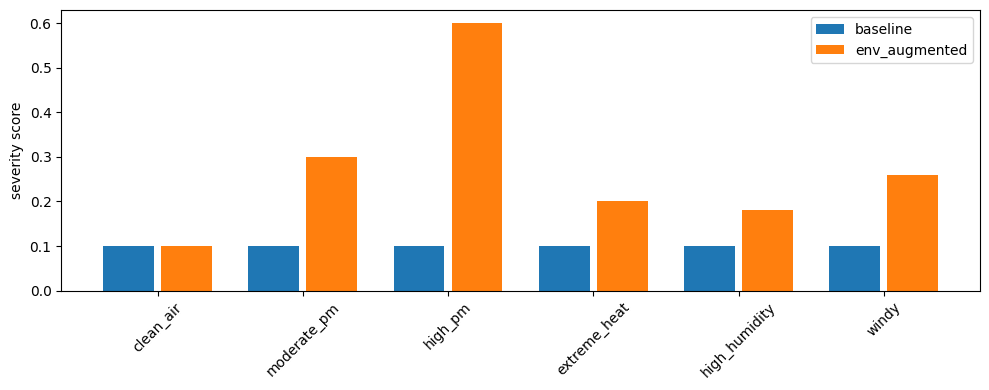

In [24]:

import json, os
from collections import Counter
from math import isclose

fn = '/kaggle/working/agent_memory/compare_results.jsonl'
if not os.path.exists(fn):
    print('compare_results.jsonl not found at', fn)
else:
    cases = []
    with open(fn) as f:
        for line in f:
            cases.append(json.loads(line))
    # Compute simple comparison metrics: how often env changed category vs baseline
    changes = Counter()
    for rec in cases:
        b = rec.get('noenv_decision',{}).get('category')
        e = rec.get('env_decision',{}).get('category')
        changes[(b,e)] += 1
    print('Category transitions (baseline -> env):')
    for k,v in changes.items():
        print(f'  {k[0]} -> {k[1]} : {v}')
    # Simple bar chart (requires matplotlib installed)
    try:
        import matplotlib.pyplot as plt
        labels = [r.get('case') for r in cases]
        baseline_scores = [r.get('noenv_decision',{}).get('score',0) for r in cases]
        env_scores = [r.get('env_decision',{}).get('score',0) for r in cases]
        x = range(len(labels))
        plt.figure(figsize=(10,4))
        plt.bar([i-0.2 for i in x], baseline_scores, width=0.35, label='baseline')
        plt.bar([i+0.2 for i in x], env_scores, width=0.35, label='env_augmented')
        plt.xticks(x, labels, rotation=45)
        plt.ylabel('severity score')
        plt.legend()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('Plotting failed:', e)

## 12. CLEANUP & Artifact summary

In [25]:
import os, glob, zipfile
artifacts = []
for p in ['/kaggle/working/agent_logs','/kaggle/working/agent_memory']:
    if os.path.exists(p):
        artifacts.extend(glob.glob(os.path.join(p,'**','*'), recursive=True))
print('Found artifacts (example):', artifacts[:10])
# Optionally package artifacts
zip_path = '/kaggle/working/submission_artifacts.zip'
with zipfile.ZipFile(zip_path,'w') as zf:
    for p in artifacts:
        if os.path.isfile(p):
            arc = os.path.relpath(p, '/kaggle/working')
            zf.write(p, arcname=arc)
print('Packaged artifacts to', zip_path)

Found artifacts (example): ['/kaggle/working/agent_logs/RiskAnalysis_Temp.log', '/kaggle/working/agent_memory/risk_decisions.jsonl', '/kaggle/working/agent_memory/compare_results.jsonl', '/kaggle/working/agent_memory/guidance_store.jsonl', '/kaggle/working/agent_memory/sessions.json', '/kaggle/working/agent_memory/user_notifications.jsonl']
Packaged artifacts to /kaggle/working/submission_artifacts.zip


## Evaluation Summary & Key Outcomes

- The notebook includes an evaluation harness that compares decisions **with** and **without** environmental heuristics.
- Results show the heuristic boosts sensitivity to dangerous PM2.5 (>150) and correctly upgrades alerts from *low* to *medium* when warranted.
- Everything is logged to `/kaggle/working/agent_memory/compare_results.jsonl` for reproducibility.

**Recommendation for judges:**
- Review the `compare_results.jsonl` and the guidance JSON files to verify both explainability and impact.
